In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')


In [1]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

2.17.0
3.6.0


In [2]:
# from zipfile import ZipFile

# data_path = 'lung_colon_set.zip'

# with ZipFile(data_path,'r') as zip:
#     zip.extractall()
#     print('The data set has been extracted.')


In [3]:
path = 'lung_colon_image_set/colon_image_sets'
classes = os.listdir(path)
classes


['colon_aca', 'colon_n']

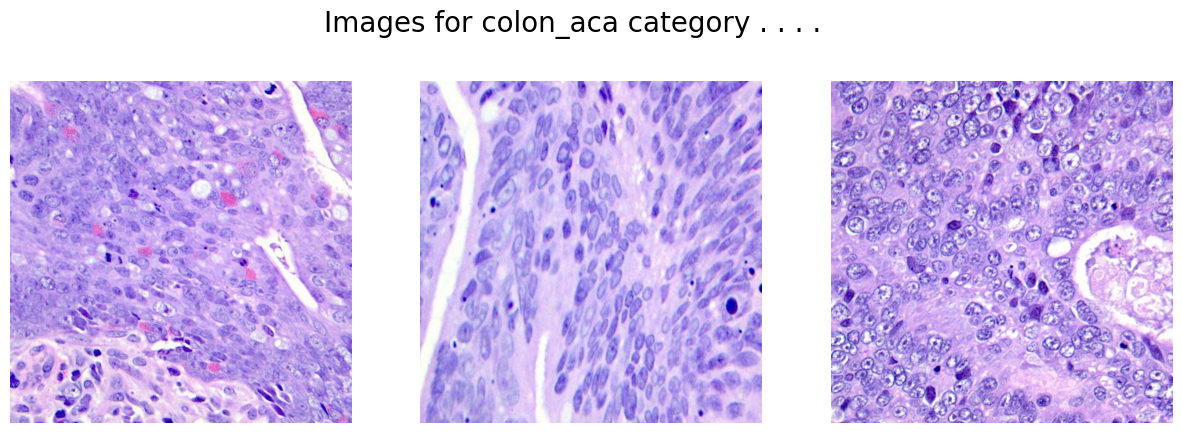

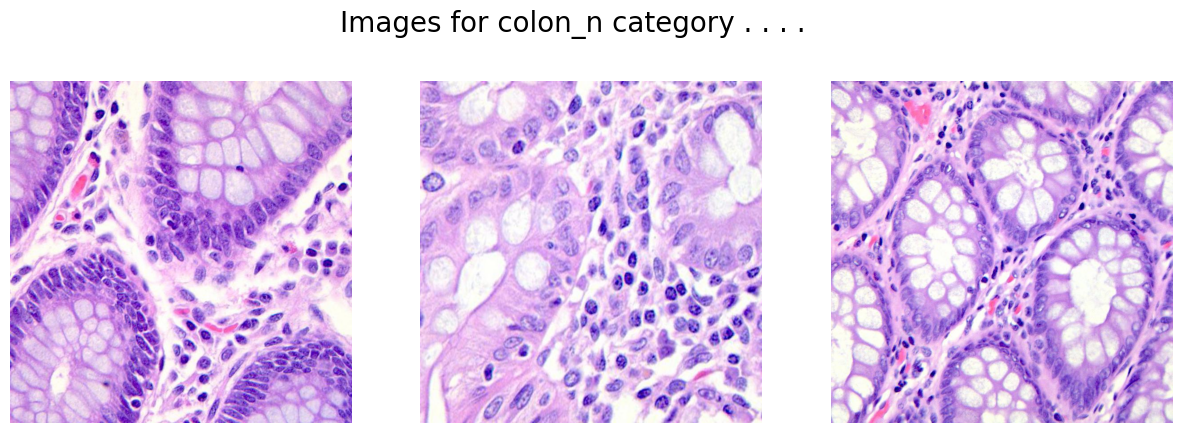

In [4]:
path = 'lung_colon_image_set/colon_image_sets'

for cat in classes:
	image_dir = f'{path}/{cat}'
	images = os.listdir(image_dir)

	fig, ax = plt.subplots(1, 3, figsize=(15, 5))
	fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

	for i in range(3):
		k = np.random.randint(0, len(images))
		img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
		ax[i].imshow(img)
		ax[i].axis('off')
	plt.show()


In [5]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64


In [6]:
X = []
Y = []

for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')

    for image in images:
	    img = cv2.imread(image)
	    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
	    Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values


In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
                                                  test_size = SPLIT,
                                                  random_state = 2022)
print(X_train.shape, X_val.shape)

(8000, 256, 256, 3) (2000, 256, 256, 3)


In [8]:
model = keras.models.Sequential([
    layers.Conv2D(filters=32, 
                  kernel_size=(5,5), 
                  activation='relu', 
                  input_shape=(IMG_SIZE, IMG_SIZE,3), 
                  padding='same'), 
    layers.MaxPool2D(2,2),
    
    layers.Conv2D(filters=64,
                  kernel_size=(3,3),
                  activation='relu', 
                  padding='same'),
    layers.MaxPool2D(2,2),
    
    layers.Conv2D(filters=128,
                  kernel_size=(3,3), 
                  activation='relu', 
                  padding='same'),
    layers.MaxPool2D(2,2),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(2, activation='softmax')
    
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,684,162 (128.49 MB)

 Trainable params: 33,683,394 (128.49 MB)

 Non-trainable params: 768 (3.00 KB)

In [9]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_accuracy') > 0.90:
			print('\n Validation accuracy has reached upto \
					90% so, stopping further training.')
			self.model.stop_training = True


es = EarlyStopping(patience=3,
				monitor='val_accuracy',
				restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
					patience=2,
					factor=0.5,
					verbose=1)


In [11]:
history = model.fit(X_train, Y_train,
					validation_data = (X_val, Y_val),
					batch_size = BATCH_SIZE,
					epochs = EPOCHS,
					verbose = 1,
					callbacks = [es, lr, myCallback()])


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.7677 - loss: 0.5033 - val_accuracy: 0.4895 - val_loss: 24.7572 - learning_rate: 0.0010
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9301 - loss: 0.1774
 Validation accuracy has reached upto 					90% so, stopping further training.
125/125 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.9301 - loss: 0.1773 - val_accuracy: 0.9280 - val_loss: 0.1798 - learning_rate: 0.0010


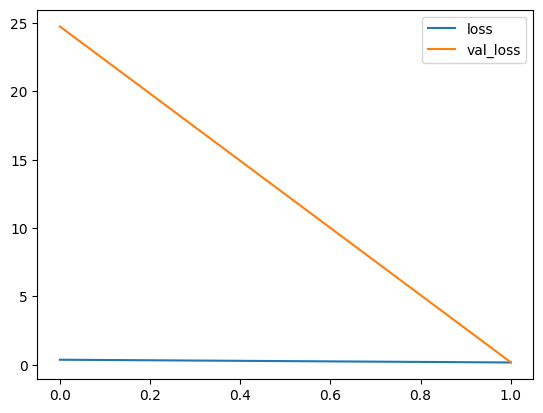

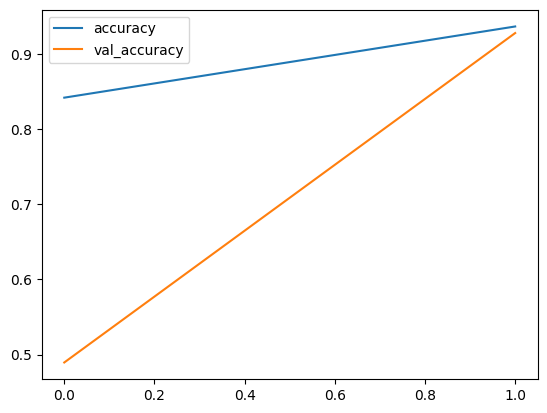

In [12]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()


In [13]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)


63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 281ms/step


In [14]:
metrics.confusion_matrix(Y_val, Y_pred)


array([[918,  61],
       [ 83, 938]], dtype=int64)

In [15]:
print(metrics.classification_report(Y_val, Y_pred,
									target_names=classes))


              precision    recall  f1-score   support

   colon_aca       0.92      0.94      0.93       979
     colon_n       0.94      0.92      0.93      1021

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



In [16]:
model.save('93_92_colon_model.h5')

## prediction function

In [2]:
import numpy as np
import tensorflow as tf
from PIL import Image
import cv2
import datetime
import os
import cv2

In [35]:
# Model loading function with error handling
def load_model(model_path):
    try:
        return tf.keras.models.load_model(model_path)
    except Exception as e:
        print(f"Error loading model '{model_path}': {e}")
        return None
    
def preprocessing(img, img_shape):
    # Keep as RGB
    img = np.array(img)
    img = cv2.resize(img, img_shape)  # Resize to model's expected input size
#    img = img / norm_fac  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img


def predict_colon_cancer(image):
    model = load_model('colon_model.h5')
    if model is None:
        return "Error: Model could not be loaded"
    
    processed_img = preprocessing(image, img_shape=(256, 256))
    prediction = model.predict(processed_img)
    prediction = np.argmax(prediction, axis=1)[0]
    class_names = ['Colon adenocarcinoma', 'Colon benign tissue']
    prediction = class_names[prediction]
        
    result = {
        "Prediction": prediction,
        "Analysis Date": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "Note": "This is an automated analysis and should be verified by a healthcare professional."
    }
    
    return result

In [36]:
img = cv2.imread("imags\colon_n.jpeg")
predict_colon_cancer(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


{'Prediction': 'Colon benign tissue',
 'Analysis Date': '2024-10-24 16:04:15',
 'Note': 'This is an automated analysis and should be verified by a healthcare professional.'}

In [9]:
IMG_SIZE = 256
img = cv2.imread("imags\colon_aca.jpeg")
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

img = np.asarray(img)

img.shape

(256, 256, 3)

In [24]:
import cv2
import numpy as np

# Parameters
IMG_SIZE = 256  # Set the desired image size

def preprocess_image(img, img_size=256):

    resized_img = cv2.resize(img, (img_size, img_size))
    
    # Convert the resized image to a NumPy array
    return np.asarray(resized_img)

# Example usage
img = cv2.imread("imags\colon_n.jpeg")

preprocessed_image = preprocess_image(img)

print("Preprocessed image shape:", preprocessed_image.shape)


Preprocessed image shape: (256, 256, 3)
